# Simulate acoustic wave propagation of an array source


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook showcases the basic functionality to perform acoustic simulations. The simulation consists of spherical section array transducer with 256 elements in an unbounded water region and a spherical scatterer resembling bone.


## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


## Specify the physical settings for the simulation

The OptimUS library provides functionality to simulate acoustic wave propagation. For each simulation, one needs to specify the type of source of the acoustic field, the geometry of the scatterer, and the material parameters.

The OptimUS library provides different predefined wave fields, among which is a spherical section array transducer radiating in 2*pi space. The array requires the frequency, element centroid locations, element radius and velocity, optionally, the source axis, and its location, which is in this case at [-0.18, 0, 0]. The elements are assumed to be planar circular piston sources. Here, uniform normal velocity of 0.4 m/s is applied to all elements of the array.

In [4]:
frequency = 500e3
a = 0.003
D = 0.18
centroid_file='default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

Several canonical shapes for scatterers are available in the OptimUS library. Let us use a spherical geometry, by default centered at the origin and unit radius. It is recommended to specify the meshwidth of the triangular surface grid that represents the geometry's surface. A lower value of `h` increases the precision of the algorithm but also the computational costs.

In [5]:
sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(r=sphere_radius, h=0.75e-3)

The exterior medium will be water and the interior medium bone. Default parameters of several materials can be retrieved from OptimUS. Alternatively, the user can create a material with specific values for density and wavespeed.

In [6]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.create_material('bone', 1912, 4080)

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. A model with default settings can be used. Alternatively, other boundary integral formulations and preconditioners can be chosen or specified manually.

Each model requires a source and geometry object, as well as the material parameters of the unbounded exterior domain and the bounded interior domain.

In [7]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

In [8]:
import bempp.api
import numpy as np
from optimus.source.transducers import transducer_field
from matplotlib import pylab as plt

In [9]:
# Create a visualisation grid
Nx = 201
Ny = 201
xmin, xmax, ymin, ymax = [-D, D, -0.05, 0.05]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

# Define the interior and exterior points
x, y = points[:2]
idx_ext = np.sqrt(x**2 + y**2) > sphere_radius
idx_int = np.logical_not(idx_ext)
points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

In [10]:
inc_field = transducer_field(source, material_ext, points, verbose=True)
incident_pressure = inc_field.pressure

Number of point sources across element diameter: 5
Number of point sources in transducer: 3328


After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

## Visualisation of the incident acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

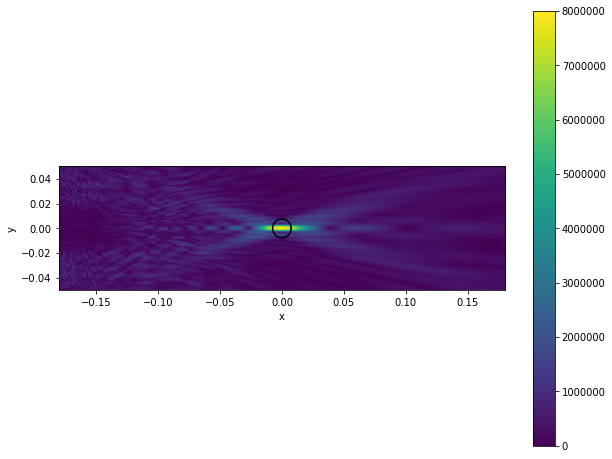

In [11]:
incident_pressure = incident_pressure.reshape([Nx, Ny])
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.flipud(np.abs(incident_pressure.T)), extent=[xmin, xmax, ymin, ymax], clim=[0,8e6], cmap='viridis')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(sphere_radius * np.cos(theta), sphere_radius * np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

## The point sources used to describe the array are plotted as a cloud of points.

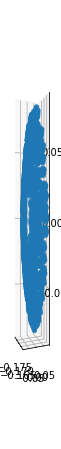

In [12]:
x = inc_field.source_locations[0, :]
y = inc_field.source_locations[1, :]
z = inc_field.source_locations[2, :]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal') 
ax.scatter(x, y, z)
ax.view_init(0,-20)
plt.show()

In [13]:
model.solve()

## Calculate the fields from the surface potential with the potential operators.

In [14]:
slp_pot_int = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
slp_pot_ext = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))
dlp_pot_int = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
dlp_pot_ext = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))

surfpot_dir_ext, surfpot_neu_ext = model.solution
surfpot_dir_int = surfpot_dir_ext
surfpot_neu_int = (material_int.density / material_ext.density) * surfpot_neu_ext
total_field_int = (slp_pot_int * surfpot_neu_int
                   - dlp_pot_int * surfpot_dir_int).ravel()
total_field_ext = (dlp_pot_ext * surfpot_dir_ext 
                   - slp_pot_ext * surfpot_neu_ext).ravel() + inc_field.pressure[idx_ext]  

total_field = np.zeros(points.shape[1], dtype='complex128')
total_field[idx_ext] = total_field_ext
total_field[idx_int] = total_field_int
total_field = total_field.reshape([Nx, Ny])

### Visualisation of real part of total field

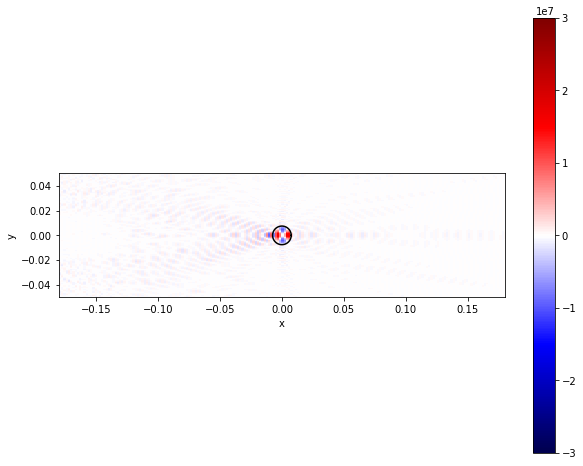

In [15]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.flipud(np.real(total_field.T)), extent=[xmin, xmax, ymin, ymax], clim=[-30e6,30e6], cmap='seismic')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(sphere_radius * np.cos(theta), sphere_radius * np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

### Visualisation of magnitude of total field

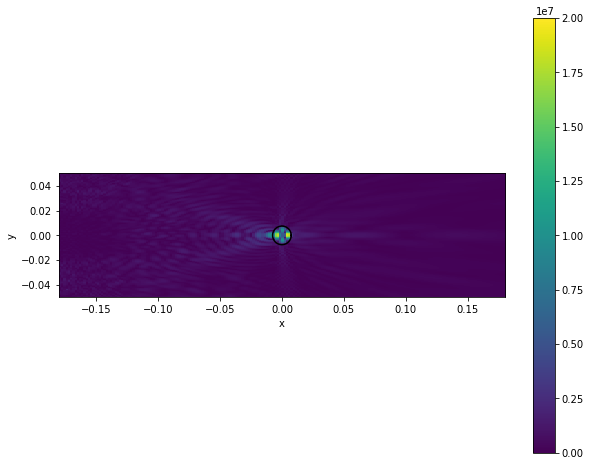

In [16]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.flipud(np.abs(total_field.T)), extent=[xmin, xmax, ymin, ymax], clim=[0,20e6], cmap='viridis')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(sphere_radius * np.cos(theta), sphere_radius * np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()